<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [71]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [72]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [73]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [74]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [75]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

In [76]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [77]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



BROS                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-05 00:00:00  30.900000  31.780001  30.799999  31.110001  31.110001   
2024-01-08 00:00:00  31.240000  31.500000  28.340000  29.690001  29.690001   
2024-01-09 00:00:00  29.469999  29.620001  28.590000  28.629999  28.629999   
2024-01-10 00:00:00  28.700001  29.760000  28.639999  29.480000  29.480000   
2024-01-11 00:00:00  29.510000  29.590000  28.230000  28.270100  28.270100   

                                 OBDC                         ...          CB  \
                        Volume   Open    High     Low  Close  ...         Low   
Date                                                          ...               
1962-01-02 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-03 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-04 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-05 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
1962-01-08 00:00:00        NaN    NaN     NaN     NaN    NaN  ...         NaN   
...                        ...    ...     ...     ...    ...  ...         ...   
2024-01-05 00:00:00  1860100.0  14.97  15.025  14.915  14.96  ...  226.630005   
2024-01-08 00:00:00  3998600.0  14.96  15.100  14.910  15.08  ...  223.690002   
2024-01-09 00:00:00  2211900.0  15.04  15.150  14.990  15.06  ...  222.860001   
2024-01-10 00:00:00  1605100.0  15.08  15.160  15.035  15.05  ...  223.550003   
2024-01-11 00:00:00  1028658.0  15.05  15.080  14.835  15.05  ...  224.740005   

                                                               PHM  \
                          Close   Adj Close     Volume        Open   
Date                                                                 
1962-01-02 00:00:00         NaN         NaN        NaN         NaN   
1962-01-03 00:00:00         NaN         NaN        NaN         NaN   
1962-01-04 00:00:00         NaN         NaN        NaN         NaN   
1962-01-05 00:00:00         NaN         NaN        NaN         NaN   
1962-01-08 00:00:00         NaN         NaN        NaN         NaN   
...                         ...         ...        ...         ...   
2024-01-05 00:00:00  227.699997  227.699997  1439200.0   99.860001   
2024-01-08 00:00:00  226.199997  226.199997  1535500.0  102.330002   
2024-01-09 00:00:00  225.309998  225.309998  1293300.0  102.550003   
2024-01-10 00:00:00  225.250000  225.250000  1716800.0  104.709999   
2024-01-11 00:00:00  227.220001  227.220001   919674.0  103.940002   

                                                                                
                           High         Low       Close   Adj Close     Volume  
Date                                                                            
1962-01-02 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-03 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-04 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-05 00:00:00         NaN         NaN         NaN         NaN        NaN  
1962-01-08 00:00:00         NaN         NaN         NaN         NaN        NaN  
...                         ...         ...         ...         ...        ...  
2024-01-05 00:00:00  102.330002   99.860001  101.480003  101.480003  1601900.0  
2024-01

In [78]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [79]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [80]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [81]:
print(stock_tickers[0])

AAON


In [82]:
# use only 10 stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: DHI
ticker historic data:                   Open        High         Low   Adj Close      Volume
Date                                                                  
1992-06-05    1.652146    1.689695    1.652146    1.126294  14561059.0
1992-06-08    1.652146    1.689695    1.652146    1.126294   1306967.0
1992-06-09    1.652146    1.652146    1.577049    1.075099   1942140.0
1992-06-10    1.577049    1.633372    1.577049    1.075099    666466.0
1992-06-11    1.577049    1.577049    1.501951    1.023904   1383534.0
...                ...         ...         ...         ...         ...
2024-01-05  147.009995  150.160004  146.570007  148.630005   2138700.0
2024-01-08  150.309998  152.440002  150.009995  152.279999   1912300.0
2024-01-09  151.000000  152.940002  150.850006  151.759995   1593100.0
2024-01-10  154.190002  156.779999  153.500000  154.520004   2211000.0
2024-01-11  153.279999  155.320007  152.625000  154.945007   1588723.0

[7959 rows x 5 columns]
ticker: MATX
ticke

In [83]:
ticker_dict.keys()

dict_keys(['DHI', 'MATX', 'CRH', 'FLEX', 'QCOM', 'LEN', 'ELF', 'TPH', 'MLM'])

In [84]:
type(list(ticker_dict.keys()))

list

In [85]:
list(ticker_dict.keys())[0]

'DHI'

In [86]:
# type(raw_df.index)

In [87]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [88]:
# raw_df

In [89]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='B') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'DHI': <TimeSeries (DataArray) (Date: 8245, component: 5, sample: 1)>
 array([[[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.12629437e+00],
         [1.45610590e+07]],
 
        [[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.12629437e+00],
         [1.30696700e+06]],
 
        [[1.65214598e+00],
         [1.65214598e+00],
         [1.57704902e+00],
         [1.07509911e+00],
         [1.94214000e+06]],
 
        ...,
 
        [[1.51000000e+02],
         [1.52940002e+02],
         [1.50850006e+02],
         [1.51759995e+02],
         [1.59310000e+06]],
 
        [[1.54190002e+02],
         [1.56779999e+02],
         [1.53500000e+02],
         [1.54520004e+02],
         [2.21100000e+06]],
 
        [[1.53279999e+02],
         [1.55320007e+02],
         [1.52625000e+02],
         [1.54945007e+02],
         [1.58872300e+06]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2024-01-1

Prepare multile series - one per stock ticker

In [90]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: DHI gaps: 
      gap_start    gap_end  gap_size
0   1992-07-03 1992-07-03         1
1   1992-09-07 1992-09-07         1
2   1992-11-26 1992-11-26         1
3   1992-12-25 1992-12-25         1
4   1993-01-01 1993-01-01         1
..         ...        ...       ...
276 2023-07-04 2023-07-04         1
277 2023-09-04 2023-09-04         1
278 2023-11-23 2023-11-23         1
279 2023-12-25 2023-12-25         1
280 2024-01-01 2024-01-01         1

[281 rows x 3 columns]
ticker: DHI gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: MATX gaps: 
      gap_start    gap_end  gap_size
0   1973-05-28 1973-05-28         1
1   1973-07-04 1973-07-04         1
2   1973-09-03 1973-09-03         1
3   1973-11-22 1973-11-22         1
4   1973-12-25 1973-12-25         1
..         ...        ...       ...
431 2023-07-04 2023-07-04         1
432 2023-09-04 2023-09-04         1
433 2023-11-23 2023-11-23         1
434 2023-12-25 2023-12-25         1
435 2024-01-01 202

In [91]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1990-01-02')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: DHI , <TimeSeries (DataArray) (Date: 8245, component: 5, sample: 1)>
array([[[1.65214598e+00],
        [1.68969500e+00],
        [1.65214598e+00],
        [1.12629437e+00],
        [1.45610590e+07]],

       [[1.65214598e+00],
        [1.68969500e+00],
        [1.65214598e+00],
        [1.12629437e+00],
        [1.30696700e+06]],

       [[1.65214598e+00],
        [1.65214598e+00],
        [1.57704902e+00],
        [1.07509911e+00],
        [1.94214000e+06]],

       ...,

       [[1.51000000e+02],
        [1.52940002e+02],
        [1.50850006e+02],
        [1.51759995e+02],
        [1.59310000e+06]],

       [[1.54190002e+02],
        [1.56779999e+02],
        [1.53500000e+02],
        [1.54520004e+02],
        [2.21100000e+06]],

       [[1.53279999e+02],
        [1.55320007e+02],
        [1.52625000e+02],
        [1.54945007e+02],
        [1.58872300e+06]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2024-01-11
  * component  (component) obje

In [92]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: DHI , <TimeSeries (DataArray) (Date: 8245, component: 6, sample: 1)>
array([[[1.65214598e+00],
        [1.68969500e+00],
        [1.65214598e+00],
        [1.12629437e+00],
        [1.45610590e+07],
        [0.00000000e+00]],

       [[1.65214598e+00],
        [1.68969500e+00],
        [1.65214598e+00],
        [1.12629437e+00],
        [1.30696700e+06],
        [0.00000000e+00]],

       [[1.65214598e+00],
        [1.65214598e+00],
        [1.57704902e+00],
        [1.07509911e+00],
        [1.94214000e+06],
        [0.00000000e+00]],
...
       [[1.51000000e+02],
        [1.52940002e+02],
        [1.50850006e+02],
        [1.51759995e+02],
        [1.59310000e+06],
        [0.00000000e+00]],

       [[1.54190002e+02],
        [1.56779999e+02],
        [1.53500000e+02],
        [1.54520004e+02],
        [2.21100000e+06],
        [0.00000000e+00]],

       [[1.53279999e+02],
        [1.55320007e+02],
        [1.52625000e+02],
        [1.54945007e+02],
        [1.58872300e+06],


In [93]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [94]:
ticker_series

{'DHI': <TimeSeries (DataArray) (Date: 8245, component: 6, sample: 1)>
 array([[[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.12629437e+00],
         [1.45610590e+07],
         [0.00000000e+00]],
 
        [[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.12629437e+00],
         [1.30696700e+06],
         [0.00000000e+00]],
 
        [[1.65214598e+00],
         [1.65214598e+00],
         [1.57704902e+00],
         [1.07509911e+00],
         [1.94214000e+06],
         [0.00000000e+00]],
 ...
        [[1.51000000e+02],
         [1.52940002e+02],
         [1.50850006e+02],
         [1.51759995e+02],
         [1.59310000e+06],
         [0.00000000e+00]],
 
        [[1.54190002e+02],
         [1.56779999e+02],
         [1.53500000e+02],
         [1.54520004e+02],
         [2.21100000e+06],
         [0.00000000e+00]],
 
        [[1.53279999e+02],
         [1.55320007e+02],
         [1.52625000e+02],
         [1.54945007

In [95]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [96]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'DHI': <TimeSeries (DataArray) (Date: 8245, component: 1, sample: 1)>
 array([[[  1.12629437]],
 
        [[  1.12629437]],
 
        [[  1.07509911]],
 
        ...,
 
        [[151.75999451]],
 
        [[154.52000427]],
 
        [[154.94500732]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2024-01-11
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'MATX': <TimeSeries (DataArray) (Date: 8878, component: 1, sample: 1)>
 array([[[  6.76645994]],
 
        [[  6.81217718]],
 
        [[  6.81217718]],
 
        ...,
 
        [[110.37000275]],
 
        [[111.58999634]],
 
        [[111.93000031]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-11
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:         

Prepare Past Covariates

In [97]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'DHI': <TimeSeries (DataArray) (Date: 8245, component: 4, sample: 1)>
 array([[[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.45610590e+07]],
 
        [[1.65214598e+00],
         [1.68969500e+00],
         [1.65214598e+00],
         [1.30696700e+06]],
 
        [[1.65214598e+00],
         [1.65214598e+00],
         [1.57704902e+00],
         [1.94214000e+06]],
 
        ...,
 
        [[1.51000000e+02],
         [1.52940002e+02],
         [1.50850006e+02],
         [1.59310000e+06]],
 
        [[1.54190002e+02],
         [1.56779999e+02],
         [1.53500000e+02],
         [2.21100000e+06]],
 
        [[1.53279999e+02],
         [1.55320007e+02],
         [1.52625000e+02],
         [1.58872300e+06]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2024-01-11
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarch

In [98]:
past_covariates.keys()

dict_keys(['DHI', 'MATX', 'CRH', 'FLEX', 'QCOM', 'LEN', 'ELF', 'TPH', 'MLM'])

DHI past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
MATX past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
CRH past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
FLEX past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

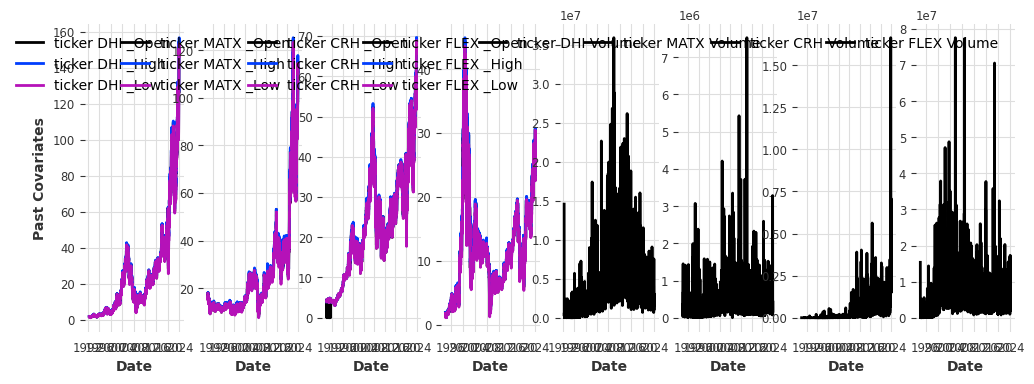

In [99]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


Stack broad market indicators to past covariates

In [100]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^NDX_Open,^NDX_High,^NDX_Low,^NDX_Adj Close,^NDX_Volume,...,^NDXE_Adj Close,^NDXE_Volume,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-05,NaN,NaN,NaN,NaN,NaN,16281.740234,16415.390625,16249.190430,16305.980469,5.232820e+09,...,6950.770020,757800.0,14.24,14.58,13.29,13.35,4.038,4.099,3.953,4.042
2024-01-08,NaN,NaN,NaN,NaN,NaN,16354.219727,16655.230469,16349.389648,16649.869141,6.337770e+09,...,7078.250000,838300.0,14.00,14.18,13.02,13.08,4.059,4.063,3.966,4.002
2024-01-09,NaN,NaN,NaN,NaN,NaN,16531.960938,16710.880859,16513.730469,16678.699219,5.068410e+09,...,7078.229980,800400.0,13.20,13.45,12.74,12.76,4.047,4.053,3.996,4.019


In [101]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='B')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 8878, component: 42, sample: 1)>
array([[[           nan],
        [           nan],
        [           nan],
        ...,
        [7.94000006e+00],
        [7.94000006e+00],
        [7.94000006e+00]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [7.98999977e+00],
        [7.98999977e+00],
        [7.98999977e+00]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
...
        ...,
        [4.05299997e+00],
        [3.99600005e+00],
        [4.01900005e+00]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [4.03800011e+00],
        [3.98499990e+00],
        [4.03000021e+00]],

       [[4.28342090e+03],
        [4.28342090e+03],
        [4.21256982e+03],
        ...,
        [4.06799984e+00],
        [3.97300005e+00],
        [3.97700000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-11
  * component  (component) object '^R2ESC_Open' ... '^TNX_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [102]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1999-04-02,1999-04-02,1
1,1999-05-31,1999-05-31,1
2,2000-04-21,2000-04-21,1
3,2000-05-29,2000-05-29,1
4,2000-09-04,2000-09-04,1
...,...,...,...
188,2023-07-04,2023-07-04,1
189,2023-09-04,2023-09-04,1
190,2023-11-23,2023-11-23,1
191,2023-12-25,2023-12-25,1


In [103]:

filler = MissingValuesFiller()

series_filled = filler.transform(broad_market_series)
series_filled.gaps()

,gap_start,gap_end


In [104]:
broad_market_series = series_filled


In [105]:
# scale series to avoid exploding gradients
#bm_scaler = Scaler(verbose=True, n_jobs=-1)
#for c in broad_market_series.columns:
#    broad_market_series[c] = 
#broad_market_series = bm_scaler.fit_transform(series=broad_market_series)
#broad_market_series

In [106]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


In [107]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


past covariates for DHI including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Close', '^R2ESC_Volume', '^NDX_Open',
       '^NDX_High', '^NDX_Low', '^NDX_Adj Close', '^NDX_Volume', '^RUT_Open',
       '^RUT_High', '^RUT_Low', '^RUT_Adj Close', '^RUT_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume', '^SPXEW_Open',
       '^SPXEW_High', '^SPXEW_Low', '^SPXEW_Adj Close', '^SPXEW_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close',
       '^NDXE_Open', '^NDXE_High', '^NDXE_Low', '^NDXE_Adj Close',
       '^NDXE_Volume', '^VIX_Open', '^VIX_High', '^VIX_Low', '^VIX_Adj Close',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Adj Close'],
      dtype='object', name='component')
past covariates for MATX including broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Clo

In [108]:
print(f'past covariates with broad market indicies: {past_covariates[t].components}')
print(f'past covariates without broad market indicies: {past_covariates[t][0]}')


past covariates with broad market indicies: Index(['Open', 'High', 'Low', 'Volume', '^R2ESC_Open', '^R2ESC_High',
       '^R2ESC_Low', '^R2ESC_Adj Close', '^R2ESC_Volume', '^NDX_Open',
       '^NDX_High', '^NDX_Low', '^NDX_Adj Close', '^NDX_Volume', '^RUT_Open',
       '^RUT_High', '^RUT_Low', '^RUT_Adj Close', '^RUT_Volume', '^SPX_Open',
       '^SPX_High', '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume', '^SPXEW_Open',
       '^SPXEW_High', '^SPXEW_Low', '^SPXEW_Adj Close', '^SPXEW_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low', 'DX-Y.NYB_Adj Close',
       '^NDXE_Open', '^NDXE_High', '^NDXE_Low', '^NDXE_Adj Close',
       '^NDXE_Volume', '^VIX_Open', '^VIX_High', '^VIX_Low', '^VIX_Adj Close',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Adj Close'],
      dtype='object', name='component')
past covariates without broad market indicies: <TimeSeries (DataArray) (Date: 1, component: 46, sample: 1)>
array([[[2.55000000e+01],
        [2.58750000e+01],
        [2.450000

Prepare Future Covariates

In [109]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'DHI': <TimeSeries (DataArray) (Date: 8245, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2024-01-11
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'MATX': <TimeSeries (DataArray) (Date: 8878, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2024-01-11
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'CRH': <TimeSeries (DataArray) (Date: 8878, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        

Prepare train and validation splits

In [110]:
val_start = pd.Timestamp('2023-05-05')
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



In [111]:
train_series, val_series

({'DHI': <TimeSeries (DataArray) (Date: 8065, component: 1, sample: 1)>
  array([[[  1.12629437]],
  
         [[  1.12629437]],
  
         [[  1.07509911]],
  
         ...,
  
         [[108.10573578]],
  
         [[109.15114594]],
  
         [[106.75167084]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1992-06-05 1992-06-08 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'MATX': <TimeSeries (DataArray) (Date: 8698, component: 1, sample: 1)>
  array([[[ 6.76645994]],
  
         [[ 6.81217718]],
  
         [[ 6.81217718]],
  
         ...,
  
         [[63.67945099]],
  
         [[63.56084824]],
  
         [[62.68121338]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1990-01-02 1990-01-03 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covaria

In [112]:
past_covariates_train, past_covariates_val

({'DHI': <TimeSeries (DataArray) (Date: 8065, component: 46, sample: 1)>
  array([[[  1.65214598],
          [  1.689695  ],
          [  1.65214598],
          ...,
          [  7.30999994],
          [  7.30999994],
          [  7.30999994]],
  
         [[  1.65214598],
          [  1.689695  ],
          [  1.65214598],
          ...,
          [  7.30999994],
          [  7.30999994],
          [  7.30999994]],
  
         [[  1.65214598],
          [  1.65214598],
          [  1.57704902],
          ...,
  ...
          ...,
          [  3.55900002],
          [  3.42400002],
          [  3.43899989]],
  
         [[108.62000275],
          [111.25      ],
          [108.59999847],
          ...,
          [  3.42400002],
          [  3.3670001 ],
          [  3.40300012]],
  
         [[109.19999695],
          [110.08999634],
          [107.15000153],
          ...,
          [  3.41100001],
          [  3.296     ],
          [  3.35100007]]])
  Coordinates:
    * Date       (

Plot data splits

Text(0, 0.5, 'Target Series')

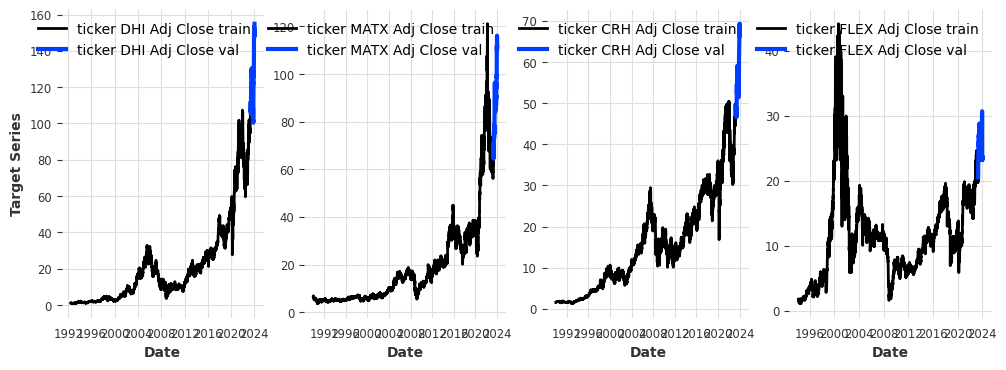

In [113]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

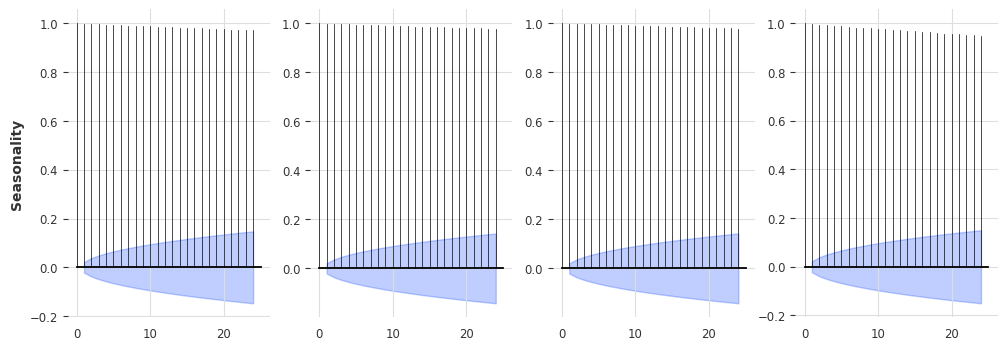

In [114]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i == n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [115]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [116]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 20 # model training epochs

Model hyperparameter selection

In [117]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [118]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model


In [119]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [120]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


9
9
9
9


In [121]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [122]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


8698
8698
8878


In [123]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1990-01-02,1.528308
1990-01-03,1.528308
1990-01-04,1.528308
1990-01-05,1.528308
1990-01-08,1.528308
...,...
2023-04-28,47.504959
2023-05-01,47.299271
2023-05-02,46.995628


In [124]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1990-01-02 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [125]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^NDX_Open,...,^NDXE_Adj Close,^NDXE_Volume,^VIX_Open,^VIX_High,^VIX_Low,^VIX_Adj Close,^TNX_Open,^TNX_High,^TNX_Low,^TNX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1990-01-02,3.950000,3.950000,3.950000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,223.835007,...,1152.489990,0.0,17.240000,17.240000,17.240000,17.240000,7.940,7.940,7.940,7.940
1990-01-03,3.950000,3.950000,3.950000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,227.725006,...,1152.489990,0.0,18.190001,18.190001,18.190001,18.190001,7.990,7.990,7.990,7.990
1990-01-04,3.950000,3.950000,3.950000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,226.100006,...,1152.489990,0.0,19.219999,19.219999,19.219999,19.219999,7.980,7.980,7.980,7.980
1990-01-05,3.950000,3.950000,3.950000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,224.714996,...,1152.489990,0.0,20.110001,20.110001,20.110001,20.110001,7.990,7.990,7.990,7.990
1990-01-08,3.950000,3.950000,3.950000,0.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,223.139999,...,1152.489990,0.0,20.260000,20.260000,20.260000,20.260000,8.020,8.020,8.020,8.020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-28,47.840000,48.639999,47.820000,809500.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13139.349609,...,5989.450195,1066400.0,17.209999,17.650000,15.720000,15.780000,3.479,3.494,3.435,3.452
2023-05-01,48.320000,48.860001,48.220001,368700.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13229.110352,...,5980.620117,828700.0,16.410000,16.620001,15.530000,16.080000,3.501,3.576,3.462,3.574
2023-05-02,47.790001,48.080002,47.380001,875000.0,4283.420898,4283.420898,4212.569824,4245.154785,0.0,13225.480469,...,5908.020020,901200.0,16.270000,19.809999,16.260000,17.780001,3.532,3.559,3.424,3.439


In [126]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1990-01-02 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [127]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    343.0
dtype: float64

In [128]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1990-01-02 00:00:00'), Timestamp('2024-01-11 00:00:00'))

In [129]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 6.7 K 
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.486    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=True, dropout=0.1, use_static_covariates=True, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders=None, n_epochs=2, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt)

In [130]:
# save model checkpoint
model.save(saved_model_name)


In [131]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [132]:
pred[0]

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[48.77230316, 49.02776195, 48.49664465, ..., 47.47369146,
         46.8538009 , 48.75710031]],

       [[45.34492014, 46.97312359, 46.51658371, ..., 50.94766797,
         48.91485121, 44.39043131]],

       [[51.87192589, 47.17297762, 49.97172559, ..., 49.34733268,
         49.25647632, 49.67744424]],

       ...,

       [[53.0903891 , 52.14638316, 49.21942751, ..., 51.52310952,
         49.97611173, 45.68283683]],

       [[52.42635798, 53.17718912, 48.26330204, ..., 53.08109206,
         50.15352329, 52.02969428]],

       [[51.04357226, 56.10484439, 51.46079974, ..., 50.34258035,
         51.61047882, 55.01860733]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [133]:
pred[0].gaps()

You are transforming a stochastic TimeSeries (i.e., contains several samples). The resulting DataFrame is a 2D object with all samples on the columns. If this is not the expected behavior consider calling a function adapted to stochastic TimeSeries like quantile_df().


,gap_start,gap_end


In [134]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

In [135]:
#pred3_series = target.slice(target.start_time(), pred2_series.end_time()+pd.Timedelta(days=60))
#pred3 = model.predict(pred_horizon, series=pred3_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred3

In [136]:
#pred4_series = target.slice(target.start_time(), pred3_series.end_time()+pd.Timedelta(days=60))
#pred4 = model.predict(pred_horizon, series=pred4_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred4

In [137]:
#pred5_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=30))
#pred5 = model.predict(pred_horizon, series=pred5_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred5

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


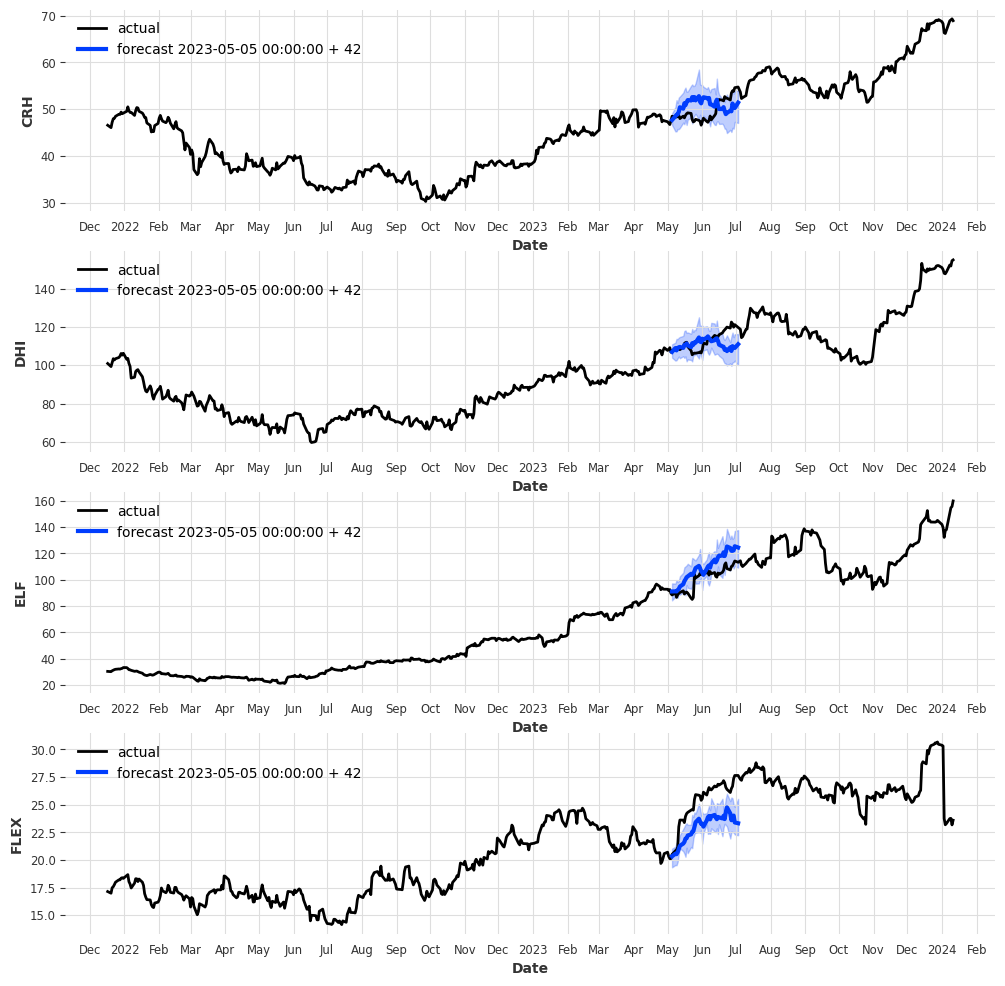

In [138]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        pred[i].plot(label=f'forecast {val_start} + {pred_horizon}', linewidth=3, ax=axes[i])
        #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
        #pred3.plot(label=f'forecast {pred3_series.end_time()} + {pred_horizon}')
        #pred4.plot(label=f'forecast {pred4_series.end_time()} + {pred_horizon}')
        #pred5.plot(label=f'forecast {pred5_series.end_time()} + {pred_horizon}')
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')




Backtest Model


Backtest model on the full range of test data

In [139]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [140]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon*2 # pred_horizon

backtest = eval_model(model=model, series=targets_list, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list, future_covariates=future_cov_list)


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


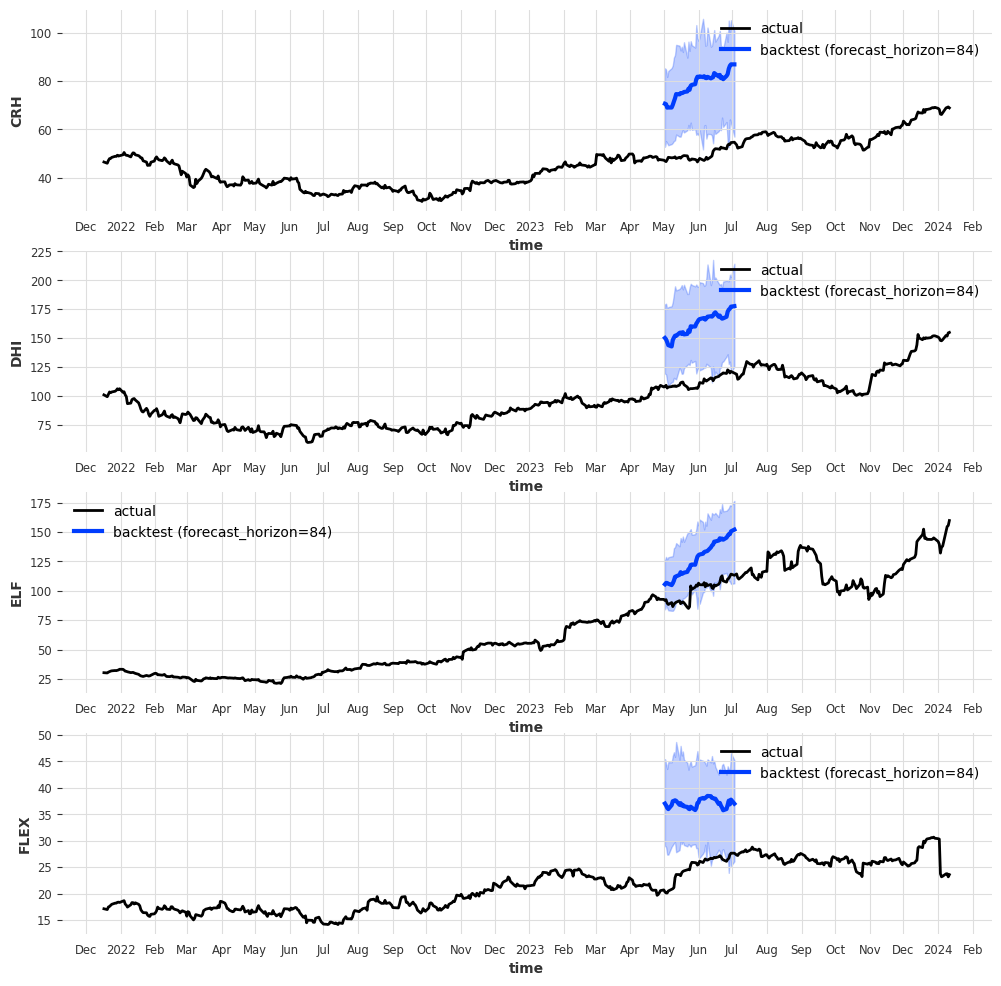

In [141]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [142]:
print('Backtest RMSE = {}'.format(rmse(target_train_list, backtest)))


Backtest RMSE = [23.00719137779976, 40.52545740137949, 15.195161217929988, 16.44530962302557, 39.58300860068971, 37.24637104468248, 185.36973655660887, 82.93803052512484, 6.6616223986641945]
